In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import pandas as pd

In [2]:
train = pd.read_csv("train_labels.csv")
sub = pd.read_csv("sub.csv")

In [3]:
train.tail()

,image,target
1303,hxjwafskxmlfaotwaklzuwuccsbxfu.jpg,0
1304,oyodauphffgmzmvqlykcfvmyxartok.jpg,1
1305,uppvtemhkneqggtbfubeccqjvyefiw.png,1
1306,mzjjvzkzvqmyukzsegtoktaslejcdz.jpg,0
1307,dbjdjyhnbvblwhhnfzaahzhdezbbib.jpg,0


In [4]:
sub.tail()

,image,target
504,zpfhbgixcctxylnihhrepjgcmjksvf.jpg,0
505,zuignwckjykxefmpubjpjefvhghaoi.jpg,0
506,zuxvwdblfwjpibjexgfglpyreqslhs.jpg,0
507,zvyajojutzgqumdjfxxkpiuuxeefyy.jpg,0
508,zynasgxnxnzqaallnvkthegctommtu.jpg,0


In [5]:
data_set = train.append(sub)

In [6]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 100
BS = 32

In [7]:
img_path = []
for image_path in data_set["image"]:
    d_path = ("images/" + str(image_path))
    #print(d_path)
    img_path.append(d_path)

In [8]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = img_path
data = []
labels = data_set.target

# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename

    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    # update the data and labels lists, respectively
    data.append(image)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)


[INFO] loading images...


In [9]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [10]:
data_train = data[:1308]
label_train = labels[:1308]
data_test = data[1308:]
label_test = labels[1308:]

In [11]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data_train, label_train, test_size=0.05, stratify=label_train, random_state=42)

In [12]:
aug = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,fill_mode="nearest")
#aug = ImageDataGenerator()

In [13]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

C:\ProgramData\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [14]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [15]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [16]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [17]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

[INFO] compiling model...


In [18]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(aug.flow(trainX, trainY, batch_size=BS),steps_per_epoch=len(trainX) // BS,validation_data=(testX, testY),validation_steps=len(testX) // BS,epochs=EPOCHS)

[INFO] training head...
  ...
    to  
  ['...']
Train for 38 steps, validate on 66 samples
Epoch 1/100
38/38 [==============================] - 74s 2s/step - loss: 0.8295 - accuracy: 0.5477 - val_loss: 0.4873 - val_accuracy: 0.7812
Epoch 2/100
38/38 [==============================] - 42s 1s/step - loss: 0.6240 - accuracy: 0.6620 - val_loss: 0.3530 - val_accuracy: 0.8594
Epoch 3/100
38/38 [==============================] - 41s 1s/step - loss: 0.5427 - accuracy: 0.7223 - val_loss: 0.2932 - val_accuracy: 0.8906
Epoch 4/100
38/38 [==============================] - 41s 1s/step - loss: 0.4774 - accuracy: 0.7694 - val_loss: 0.2671 - val_accuracy: 0.9375
Epoch 5/100
38/38 [==============================] - 41s 1s/step - loss: 0.4654 - accuracy: 0.7769 - val_loss: 0.2237 - val_accuracy: 0.9219
Epoch 6/100
38/38 [==============================] - 41s 1s/step - loss: 0.4175 - accuracy: 0.8083 - val_loss: 0.2084 - val_accuracy: 0.9219
Epoch 7/100
38/38 [==============================] - 41s 1s/st

Epoch 58/100
38/38 [==============================] - 42s 1s/step - loss: 0.1947 - accuracy: 0.9190 - val_loss: 0.1340 - val_accuracy: 0.9375
Epoch 59/100
38/38 [==============================] - 42s 1s/step - loss: 0.2063 - accuracy: 0.9149 - val_loss: 0.1328 - val_accuracy: 0.9531
Epoch 60/100
38/38 [==============================] - 42s 1s/step - loss: 0.1868 - accuracy: 0.9207 - val_loss: 0.1306 - val_accuracy: 0.9531
Epoch 61/100
38/38 [==============================] - 42s 1s/step - loss: 0.1831 - accuracy: 0.9248 - val_loss: 0.1284 - val_accuracy: 0.9531
Epoch 62/100
38/38 [==============================] - 45s 1s/step - loss: 0.1966 - accuracy: 0.9198 - val_loss: 0.1303 - val_accuracy: 0.9375
Epoch 63/100
38/38 [==============================] - 45s 1s/step - loss: 0.2161 - accuracy: 0.9182 - val_loss: 0.1346 - val_accuracy: 0.9375
Epoch 64/100
38/38 [==============================] - 43s 1s/step - loss: 0.1930 - accuracy: 0.9281 - val_loss: 0.1369 - val_accuracy: 0.9375
Epoch 

In [19]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [20]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [21]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96        34
           1       0.94      0.97      0.95        32

    accuracy                           0.95        66
   macro avg       0.95      0.95      0.95        66
weighted avg       0.96      0.95      0.95        66



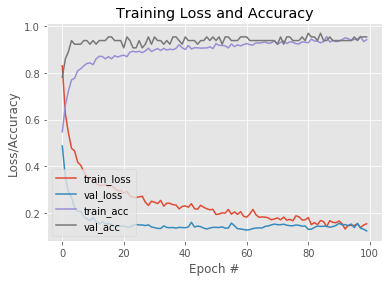

In [22]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [23]:
predictions = model.predict(data_test,batch_size=BS)

In [24]:
predictions = predictions[:,1:2]

In [25]:
predictions

array([[2.39303276e-01],
       [1.72487888e-02],
       [9.99996901e-01],
       [5.89884102e-01],
       [1.86063902e-04],
       [9.58593620e-04],
       [9.99589264e-01],
       [4.17363364e-03],
       [1.71462998e-01],
       [9.69981432e-01],
       [2.77574709e-05],
       [1.26059796e-03],
       [9.99944210e-01],
       [9.99999404e-01],
       [9.96812403e-01],
       [4.84338868e-03],
       [9.98431504e-01],
       [9.99982715e-01],
       [3.46146338e-03],
       [8.99257302e-01],
       [5.29831767e-01],
       [5.32924943e-03],
       [9.99990582e-01],
       [6.43930034e-05],
       [5.81202246e-02],
       [9.93526697e-01],
       [9.99866247e-01],
       [8.86192538e-06],
       [9.99933600e-01],
       [9.97911274e-01],
       [8.24987769e-01],
       [2.66116438e-03],
       [9.99995351e-01],
       [9.79693174e-01],
       [9.86716747e-01],
       [2.43325179e-04],
       [1.58376452e-06],
       [9.99860048e-01],
       [3.24054490e-05],
       [5.88440597e-01],


In [26]:
sub

,image,target
0,aadawlxbmapqrblgxyzarhjasgiobu.png,0
1,abpxvdfyhaaohzcrngcucmhffwizxs.jpg,0
2,aclkjfvackiieiznzfcwienplielrj.jpg,0
3,aelkivmayxgsdjosiibfgmkvfrjvjk.jpg,0
4,aelzzshpfxerelefnkatpczktuxjln.jpg,0
...,...,...
504,zpfhbgixcctxylnihhrepjgcmjksvf.jpg,0
505,zuignwckjykxefmpubjpjefvhghaoi.jpg,0
506,zuxvwdblfwjpibjexgfglpyreqslhs.jpg,0
507,zvyajojutzgqumdjfxxkpiuuxeefyy.jpg,0


In [27]:
sub.target = predictions

In [28]:
sub

,image,target
0,aadawlxbmapqrblgxyzarhjasgiobu.png,0.239303
1,abpxvdfyhaaohzcrngcucmhffwizxs.jpg,0.017249
2,aclkjfvackiieiznzfcwienplielrj.jpg,0.999997
3,aelkivmayxgsdjosiibfgmkvfrjvjk.jpg,0.589884
4,aelzzshpfxerelefnkatpczktuxjln.jpg,0.000186
...,...,...
504,zpfhbgixcctxylnihhrepjgcmjksvf.jpg,0.000157
505,zuignwckjykxefmpubjpjefvhghaoi.jpg,0.009071
506,zuxvwdblfwjpibjexgfglpyreqslhs.jpg,0.974086
507,zvyajojutzgqumdjfxxkpiuuxeefyy.jpg,0.997944


In [29]:
sub.to_csv("nose_mask_zooming_100_detect_003.csv",index = False)

In [30]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('my_model.h5') 